In [ ]:
import os
# Name of the Google Drive folder for this homework.
gdrive_root = '/content/drive/MyDrive'

from google.colab import drive
if not os.path.ismount("/content/drive"):
  drive.mount('/content/drive')
if not os.path.isdir(gdrive_root):
  os.makedirs(gdrive_root)

os.listdir('/content/drive')

Mounted at /content/drive


['MyDrive', 'Shareddrives', '.shortcut-targets-by-id', '.Trash-0']

In [ ]:
# =========================
# 1) Imports & parameters
# =========================
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Louvain (python-louvain)
import community.community_louvain as community_louvain


# Optional 2D embedding for cleaner plots
import umap

# Output locations
OUT_DIR = "/content"
MOD_MEMBERSHIP_CSV = os.path.join(OUT_DIR, "module_memberships.csv")
MOD_SUMMARY_CSV    = os.path.join(OUT_DIR, "module_summary.csv")
FIG_UMAP_PNG       = os.path.join(OUT_DIR, "hsdn_louvain_umap.png")
FIG_SPRING_PNG     = os.path.join(OUT_DIR, "hsdn_louvain_spring.png")

# Optional: edge weight threshold to denoise & speed plotting (kept OFF by default)
MIN_W = 0.5  # e.g., set to 0.10 to keep edges with weight >= 0.10
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


## Load the edge list

In [ ]:
# ---------- 1) Load the Supplementary Data 4 edge list ----------
# The file should have 3 columns:
#   Col1: MeSH Disease Term (disease A)
#   Col2: MeSH Disease Term (disease B)
#   Col3: symptom similarity score (float)
# Set the path and separator as appropriate (tab- or comma-separated).
PATH = "/content/drive/MyDrive/41467_2014_BFncomms5212_MOESM1046_ESM.txt"    # <--- change to your filename
SEP = "\t"                           # "\t" for TSV; use "," if CSV

df = pd.read_csv(PATH, sep=SEP, header=0)

# Normalize column names to standard names
# Handle cases like duplicate column name "MeSH Disease Term.1"
cols = list(df.columns)
src_col, dst_col, w_col = cols[0], cols[1], cols[2]
df = df.rename(columns={src_col: "disease1", dst_col: "disease2", w_col: "weight"})

# Optionally drop self-loops & NaNs, and ensure numeric weights
df = df.dropna(subset=["disease1", "disease2", "weight"])
df = df[df["disease1"] != df["disease2"]]
df["weight"] = pd.to_numeric(df["weight"], errors="coerce")
df = df.dropna(subset=["weight"])

print(f"Loaded edges: {len(df):,}")
print(df.head(3))

Loaded edges: 133,106
                       disease1                         disease2    weight
0  Histiocytoma, Benign Fibrous                         Aneurysm  0.591937
1  Histiocytoma, Benign Fibrous            Carcinoma, Basal Cell  0.310479
2       Arthropathy, Neurogenic  Corneal Dystrophies, Hereditary  0.133123


In [ ]:
# ======================================
# 3) (Optional) apply edge weight filter
# ======================================
if MIN_W is not None:
    before = len(df)
    df = df[df["weight"] >= float(MIN_W)].copy()
    after = len(df)
    print(f"Applied MIN_W={MIN_W:.3f}: {before:,} -> {after:,} edges")


Applied MIN_W=0.500: 133,106 -> 9,792 edges


## Build the weighted undirected graph

In [ ]:
# ==========================
# 4) Build graph and prune
# ==========================
G = nx.from_pandas_edgelist(
    df, source="disease1", target="disease2", edge_attr=["weight"], create_using=nx.Graph
)

# Instead of nx.info(G)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Keep the largest connected component for stability of community detection & plotting
if not nx.is_connected(G):
    largest_cc_nodes = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc_nodes).copy()
    print("Kept largest connected component:",
          G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


Graph: 1367 nodes, 9792 edges
Kept largest connected component: 1342 nodes, 9775 edges


In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = 2 * num_edges / num_nodes

print(f"Nodes: {num_nodes:,}")
print(f"Edges: {num_edges:,}")
print(f"Density: {density:.6f}")
print(f"Average degree: {avg_degree:.2f}")


Nodes: 1,342
Edges: 9,775
Density: 0.010863
Average degree: 14.57


##  Louvain community detection (Q)

In [ ]:
# =====================================
# 5) Louvain community detection (Q)
# =====================================
partition = community_louvain.best_partition(G, weight='weight', random_state=RNG_SEED)
Q = community_louvain.modularity(partition, G, weight='weight')
print(f"Modularity Q = {Q:.3f}")

# Save membership table
modules_df = pd.Series(partition, name="module").reset_index()
modules_df.columns = ["disease", "module"]
modules_df.to_csv(MOD_MEMBERSHIP_CSV, index=False)
print("Saved module memberships ->", MOD_MEMBERSHIP_CSV)

# Basic module stats
mod_counts = modules_df["module"].value_counts().sort_values(ascending=False)
print("Number of modules:", mod_counts.size)
print("Top 10 module sizes:\n", mod_counts.head(10))


Modularity Q = 0.742
Saved module memberships -> /content/module_memberships.csv
Number of modules: 18
Top 10 module sizes:
 module
2     188
10    173
4     160
7     141
0     113
9      98
12     96
5      77
16     65
11     63
Name: count, dtype: int64


## Summary

In [142]:
# ===============================================
# 6) Summaries for Methods/Results table (CSV)
# ===============================================
top_k = 18  # show top 8 largest modules
rows = []
for m in mod_counts.head(top_k).index.tolist():
    members = modules_df.loc[modules_df["module"] == m, "disease"].tolist()
    rows.append({
        "module_id": int(m),
        "size": len(members),
        "example_diseases": "; ".join(members[:10])  # first 10 exemplars
    })
summary_df = pd.DataFrame(rows).sort_values("size", ascending=False)
summary_df.to_csv(MOD_SUMMARY_CSV, index=False)
summary_df


,module_id,size,example_diseases
0,2,188,"Alzheimer Disease; Memory Disorders; Dementia,..."
1,10,173,Gallbladder Neoplasms; Hepatic Encephalopathy;...
2,4,160,Wolf-Hirschhorn Syndrome; Nevus; Coloboma; Smi...
3,7,141,"Splenomegaly; Cholestasis; Leukemia, Myeloid, ..."
4,0,113,"Histiocytoma, Benign Fibrous; Aneurysm; Liposa..."
5,9,98,Pituitary Neoplasms; Glaucoma; Uveitis; Glauco...
6,12,96,"Adrenocortical Hyperfunction; Infertility, Fem..."
7,5,77,Mitral Valve Prolapse; Aortic Valve Stenosis; ...
8,16,65,"Arthritis, Experimental; Hypoproteinemia; Lymp..."
9,11,63,Charcot-Marie-Tooth Disease; Muscular Diseases...


##  Basic network statistics

In [145]:
# ==================================
# 7) Basic network statistics text
# ==================================
n = G.number_of_nodes()
m = G.number_of_edges()
deg = np.array([d for _, d in G.degree(weight=None)], dtype=float)
wdeg = np.array([d for _, d in G.degree(weight="weight")], dtype=float)

print(f"Nodes: {n}, Edges: {m}")
print(f"Density: {nx.density(G):.6f}")
print(f"Avg degree (unweighted): {deg.mean():.2f} ± {deg.std():.2f}")
print(f"Avg weighted degree: {wdeg.mean():.2f} ± {wdeg.std():.2f}")


Nodes: 1342, Edges: 9775
Density: 0.010863
Avg degree (unweighted): 14.57 ± 17.75
Avg weighted degree: 9.59 ± 12.15


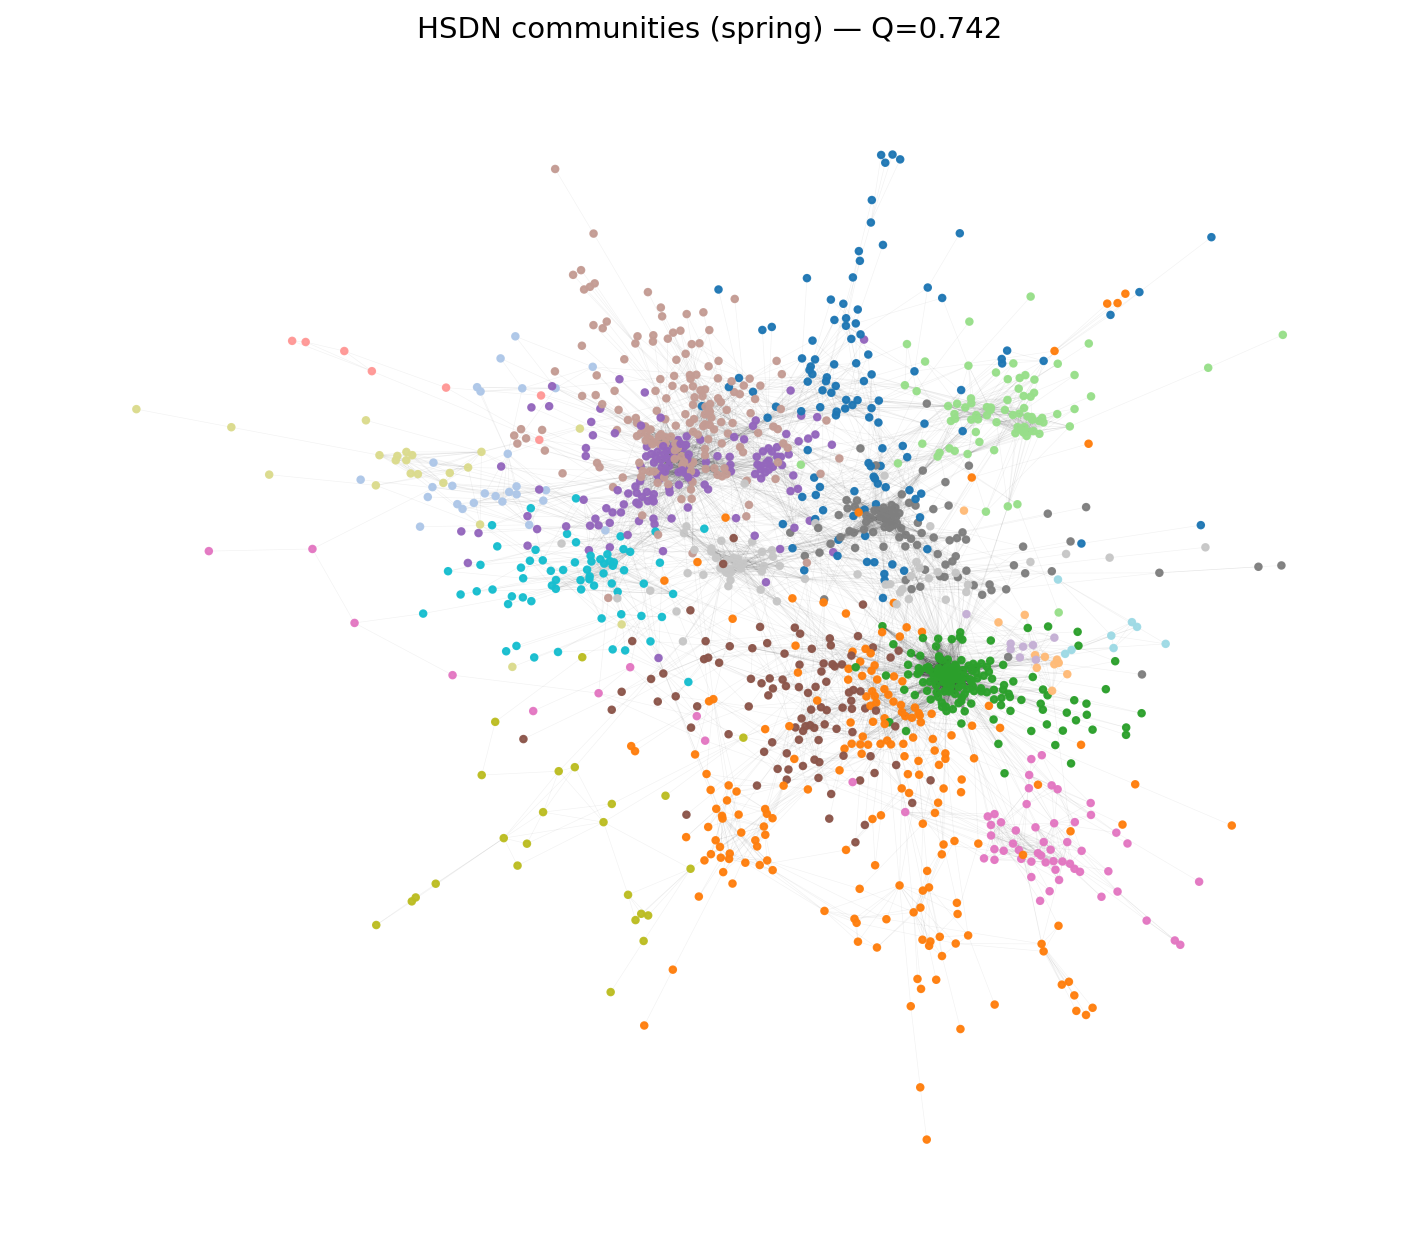

In [147]:
# Keep only a backbone of strongest edges for plotting
E = sorted(G.edges(data=True), key=lambda e: e[2].get("weight", 0.0), reverse=True)
E_draw = [(u,v) for (u,v,_) in E[: max(10000, int(0.2*len(E)))]]  # cap or 20%

pos = nx.spring_layout(G, seed=RNG_SEED, weight="weight", iterations=200)

plt.figure(figsize=(9,8), dpi=160)
nx.draw_networkx_edges(G, pos, edgelist=E_draw, alpha=0.05, width=0.3)
nx.draw_networkx_nodes(G, pos, node_size=8,
                       node_color=[node_to_module.get(n, -1) for n in G.nodes()],
                       cmap="tab20", alpha=0.95)
plt.title(f"HSDN communities (spring) — Q={Q:.3f}")
plt.axis("off")
plt.tight_layout()
plt.show()


In [146]:
# Show top modules with 6 exemplar diseases each
for _, row in summary_df.iterrows():
    m, sz = row["module_id"], row["size"]
    ex = row["example_diseases"].split("; ")[:6]
    print(f"Module {m:>2}  (n={sz}):  " + ", ".join(ex))


Module  2  (n=188):  Alzheimer Disease, Memory Disorders, Dementia, Vascular, Cognition Disorders, Epilepsy, Temporal Lobe, Amphetamine-Related Disorders
Module 10  (n=173):  Gallbladder Neoplasms, Hepatic Encephalopathy, Hepatic Veno-Occlusive Disease, Cholangitis, Sclerosing, Pancreatitis, Spherocytosis, Hereditary
Module  4  (n=160):  Wolf-Hirschhorn Syndrome, Nevus, Coloboma, Smith-Lemli-Opitz Syndrome, Nails, Malformed, Orofaciodigital Syndromes
Module  7  (n=141):  Splenomegaly, Cholestasis, Leukemia, Myeloid, Acute, Hepatomegaly, Pancytopenia, Lymphoma, T-Cell
Module  0  (n=113):  Histiocytoma, Benign Fibrous, Aneurysm, Liposarcoma, Papilloma, Mesothelioma, Respiratory Distress Syndrome, Adult
Module  9  (n=98):  Pituitary Neoplasms, Glaucoma, Uveitis, Glaucoma, Open-Angle, Retinal Diseases, Choroidal Neovascularization
Module 12  (n=96):  Adrenocortical Hyperfunction, Infertility, Female, Dermatitis, Seborrheic, Pituitary ACTH Hypersecretion, Lipodystrophy, Familial Partial, Ne

## Helper functions (build graph, Louvain repeats, consensus, metrics)

In [ ]:
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
import random
import community.community_louvain as community_louvain
from sklearn.metrics import adjusted_rand_score

def build_graph_from_df(df_edges):
    """Undirected weighted graph from an edge list df (disease1, disease2, weight)."""
    G = nx.from_pandas_edgelist(
        df_edges, "disease1", "disease2", edge_attr=["weight"], create_using=nx.Graph
    )
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    return G

def louvain_runs(G, gamma=1.0, n_runs=150, weight='weight', seed=42):
    """Run Louvain n_runs times; return list of partitions and list of Q values."""
    parts, Qs = [], []
    for i in range(n_runs):
        rs = None if seed is None else (seed + i)
        part = community_louvain.best_partition(G, weight=weight, resolution=gamma, random_state=rs)
        Q = community_louvain.modularity(part, G, weight=weight)
        parts.append(part)
        Qs.append(Q)
    return parts, np.array(Qs)

def consensus_partition(parts):
    """Build co-association matrix, threshold at 0.5, recluster with Louvain."""
    nodes = list(parts[0].keys())
    idx = {n:i for i,n in enumerate(nodes)}
    n = len(nodes)
    C = np.zeros((n, n), dtype=float)
    for p in parts:
        labels = np.array([p[n] for n in nodes])
        eq = (labels[:,None] == labels[None,:]).astype(float)
        C += eq
    C /= len(parts)
    H = nx.Graph()
    H.add_nodes_from(nodes)
    th = 0.5
    ii, jj = np.where((C >= th) & (np.triu(np.ones_like(C), 1)==1))
    for a, b in zip(ii, jj):
        H.add_edge(nodes[a], nodes[b], weight=C[a,b])
    cons = {}
    for cc in nx.connected_components(H) if H.number_of_edges()>0 else [set(nodes)]:
        sub = H.subgraph(cc).copy()
        if sub.number_of_edges() == 0:
            for u in sub.nodes():
                cons[u] = u
            continue
        cp = community_louvain.best_partition(sub, weight='weight', resolution=1.0, random_state=42)
        for u, c in cp.items():
            cons[u] = f"{len(cons)}_{c}"
    comm_ids = {c:i for i,c in enumerate(pd.Series(cons).unique())}
    cons_int = {u: comm_ids[c] for u, c in cons.items()}
    return cons_int

def partition_stats(part):
    """Return (# communities, average size)."""
    sizes = Counter(part.values())
    k = len(sizes)
    avg = np.mean(list(sizes.values())) if k>0 else 0
    return k, avg


def ari_between(p1, p2, min_common=2):
    """
    ARI on the intersection of nodes present in both partitions.
    Returns np.nan if the common set is too small.
    """
    common = sorted(set(p1.keys()).intersection(p2.keys()))
    if len(common) < min_common:
        return np.nan
    y1 = [p1[n] for n in common]
    y2 = [p2[n] for n in common]
    return adjusted_rand_score(y1, y2)


## Define sparsity sweep (like ρ) and γ grid

We can do quantile thresholds (keep top X% edges by weight) or absolute cutoffs. Here are some quantiles—edits:

In [ ]:
# Choose quantiles as "ρ-like" sparsity levels (higher q => denser graph)
quantiles = [0.50, 0.60, 0.70, 0.80, 0.90]  # keep edges with weight >= q-quantile
# (You can add more levels, but each adds runtime.)

# γ sweep like the paper: 0.25 to 3.0
gamma_grid = np.arange(0.25, 3.01, 0.25)
N_RUNS = 150


In [ ]:
# Install (Colab): uncomment the next line once
# !pip -q install networkx python-louvain scikit-learn matplotlib pandas

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain  # correct import

from collections import Counter
from sklearn.metrics import adjusted_rand_score

RNG_SEED = 42
np.random.seed(RNG_SEED)

def build_graph_from_df(df_edges):
    G = nx.from_pandas_edgelist(
        df_edges, "disease1", "disease2", edge_attr=["weight"], create_using=nx.Graph
    )
    # Giant component (keeps node set stable within each (ρ,γ) run)
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    return G

def louvain_runs(G, gamma=1.0, n_runs=150, weight="weight", seed=RNG_SEED):
    """Return per-run partitions + Qs + per-run metrics (#comms, avg size)."""
    parts, Qs, k_list, avg_list = [], [], [], []
    nodes = list(G.nodes())
    for i in range(n_runs):
        rs = None if seed is None else (seed + i)
        part = community_louvain.best_partition(G, weight=weight, resolution=gamma, random_state=rs)
        Q = community_louvain.modularity(part, G, weight=weight)
        # per-run metrics
        sizes = Counter(part.values())
        k_list.append(len(sizes))
        avg_list.append(np.mean(list(sizes.values())) if sizes else np.nan)

        parts.append(part); Qs.append(Q)
    return parts, np.asarray(Qs), np.asarray(k_list), np.asarray(avg_list)


In [ ]:
# Sparsity levels (ρ) via edge-weight quantiles — edit as you wish
rhos = [0.50, 0.60, 0.70, 0.80, 0.90]   # keep edges >= weight quantile ρ

# Resolution sweep (γ)
gamma_grid = np.arange(0.25, 3.01, 0.25)

# Runs per (ρ,γ); use 150 to match the paper (reduce to 50 for speed while testing)
N_RUNS = 150


In [ ]:
records = []

# Precompute cut values for speed
cut_values = {rho: df["weight"].quantile(rho) for rho in rhos}

for rho in rhos:
    cut = cut_values[rho]
    df_rho = df[df["weight"] >= cut].copy()
    G_rho  = build_graph_from_df(df_rho)
    print(f"[ρ={rho:.2f}] nodes={G_rho.number_of_nodes():,}, edges={G_rho.number_of_edges():,}, density={nx.density(G_rho):.4f}")

    # Accumulate Q(γ) to estimate an "inflection-like" γ (smallest |ΔQ|)
    Q_medians_for_gamma = {}

    for gamma in gamma_grid:
        parts, Qs, K, AVG = louvain_runs(G_rho, gamma=gamma, n_runs=N_RUNS, weight="weight", seed=RNG_SEED)

        rec = {
            "rho": rho, "gamma": gamma,
            # Q distribution
            "Q_med": np.median(Qs),
            "Q_lo":  np.percentile(Qs, 2.5),
            "Q_hi":  np.percentile(Qs, 97.5),
            "Q_q25": np.percentile(Qs, 25),
            "Q_q75": np.percentile(Qs, 75),
            # # communities distribution
            "K_med": np.median(K),
            "K_lo":  np.percentile(K, 2.5),
            "K_hi":  np.percentile(K, 97.5),
            "K_q25": np.percentile(K, 25),
            "K_q75": np.percentile(K, 75),
            # avg community size distribution
            "S_med": np.median(AVG),
            "S_lo":  np.percentile(AVG, 2.5),
            "S_hi":  np.percentile(AVG, 97.5),
            "S_q25": np.percentile(AVG, 25),
            "S_q75": np.percentile(AVG, 75),
        }
        records.append(rec)
        Q_medians_for_gamma[gamma] = rec["Q_med"]

    # pick “inflection-like” γ: smallest |ΔQ| (right edge of min interval)
    gs = sorted(Q_medians_for_gamma.keys())
    dQ = [abs(Q_medians_for_gamma[gs[i+1]] - Q_medians_for_gamma[gs[i]]) for i in range(len(gs)-1)]
    gamma_inflect = gs[np.argmin(dQ)+1] if len(dQ)>0 else 1.0
    print(f"  ⇒ γ* (inflection-like) ≈ {gamma_inflect:.2f}")


[ρ=0.50] nodes=987, edges=4,777, density=0.0098
  ⇒ γ* (inflection-like) ≈ 1.25
[ρ=0.60] nodes=803, edges=3,631, density=0.0113
  ⇒ γ* (inflection-like) ≈ 1.00
[ρ=0.70] nodes=605, edges=2,577, density=0.0141
  ⇒ γ* (inflection-like) ≈ 1.25
[ρ=0.80] nodes=92, edges=733, density=0.1751
  ⇒ γ* (inflection-like) ≈ 0.50
[ρ=0.90] nodes=49, edges=289, density=0.2457
  ⇒ γ* (inflection-like) ≈ 2.75


In [ ]:
results = pd.DataFrame(records)
results.head()


,rho,gamma,Q_med,Q_lo,Q_hi,Q_q25,Q_q75,K_med,K_lo,K_hi,K_q25,K_q75,S_med,S_lo,S_hi,S_q25,S_q75
0,0.5,0.25,0.774249,0.766502,0.779320,0.771453,0.775931,80.0,76.0,87.000,78.0,82.00,12.337500,11.344828,12.986842,12.036585,12.653846
1,0.5,0.50,0.801767,0.798156,0.802595,0.801217,0.802094,23.0,20.0,25.275,22.0,24.00,42.913043,39.062423,49.350000,41.125000,44.863636
2,0.5,0.75,0.803697,0.802431,0.804583,0.803240,0.804149,25.0,21.0,28.000,24.0,26.00,39.480000,35.250000,47.000000,37.961538,41.125000
3,0.5,1.00,0.805031,0.804198,0.805190,0.804870,0.805163,25.0,24.0,27.000,25.0,25.00,39.480000,36.555556,41.125000,39.480000,39.480000
4,0.5,1.25,0.804740,0.803854,0.804907,0.804602,0.804767,27.0,26.0,28.000,27.0,27.75,36.555556,35.250000,37.961538,35.576389,36.555556


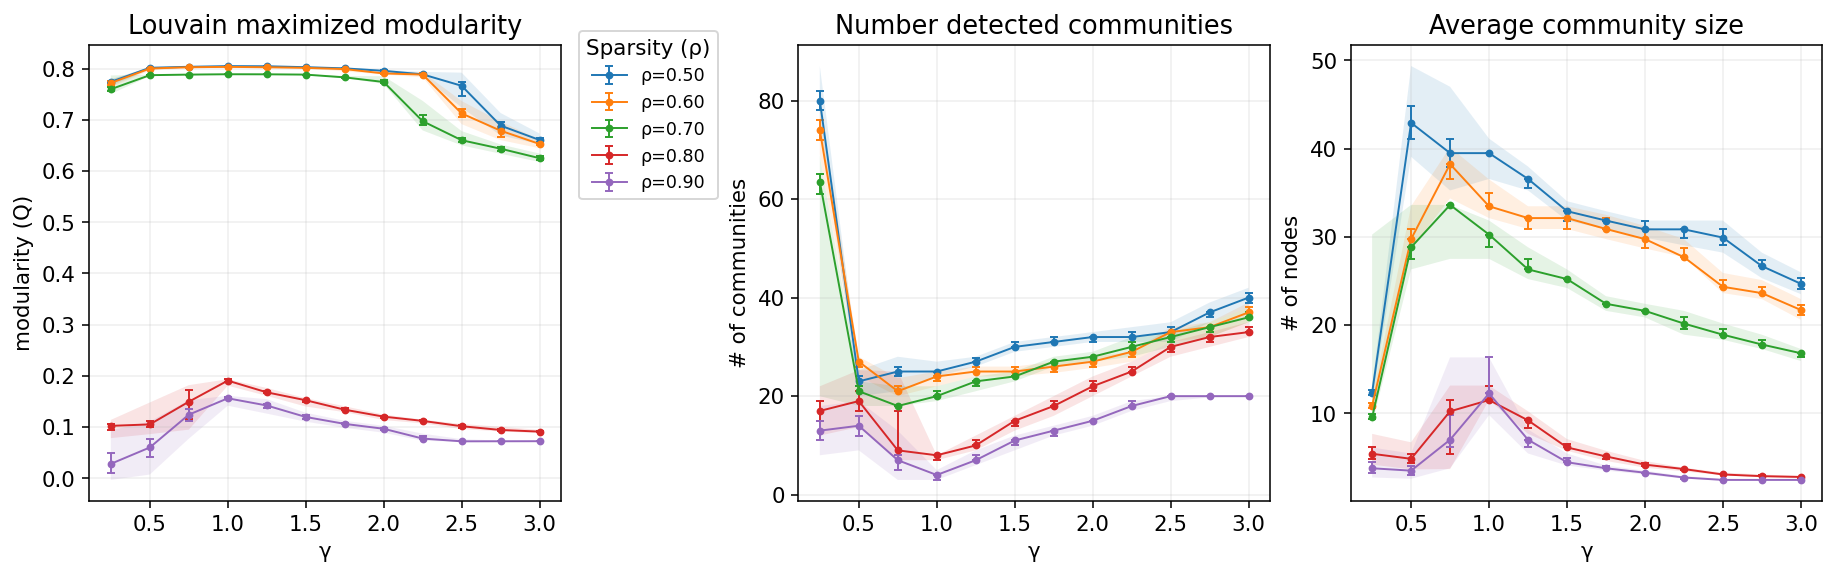

In [129]:
# Style
plt.rcParams.update({"figure.dpi": 140, "font.size": 11})

fig, axes = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)

# Panel 1: Louvain maximized modularity (Q)
ax = axes[0]
for rho in rhos:
    sub = results[results["rho"]==rho].sort_values("gamma")
    ax.fill_between(sub["gamma"], sub["Q_lo"],  sub["Q_hi"], alpha=0.12)
    ax.errorbar(sub["gamma"], sub["Q_med"],
                yerr=[sub["Q_med"]-sub["Q_q25"], sub["Q_q75"]-sub["Q_med"]],
                fmt='-o', ms=3, lw=1, capsize=2, label=f"ρ={rho:.2f}")
ax.set_xlabel(r"γ")
ax.set_ylabel("modularity (Q)")
ax.set_title("Louvain maximized modularity")
ax.grid(alpha=0.2)

# Panel 2: Number of detected communities
ax = axes[1]
for rho in rhos:
    sub = results[results["rho"]==rho].sort_values("gamma")
    ax.fill_between(sub["gamma"], sub["K_lo"],  sub["K_hi"], alpha=0.12)
    ax.errorbar(sub["gamma"], sub["K_med"],
                yerr=[sub["K_med"]-sub["K_q25"], sub["K_q75"]-sub["K_med"]],
                fmt='-o', ms=3, lw=1, capsize=2, label=f"ρ={rho:.2f}")
ax.set_xlabel(r"γ")
ax.set_ylabel("# of communities")
ax.set_title("Number detected communities")
ax.grid(alpha=0.2)

# Panel 3: Average community size
ax = axes[2]
for rho in rhos:
    sub = results[results["rho"]==rho].sort_values("gamma")
    ax.fill_between(sub["gamma"], sub["S_lo"],  sub["S_hi"], alpha=0.12)
    ax.errorbar(sub["gamma"], sub["S_med"],
                yerr=[sub["S_med"]-sub["S_q25"], sub["S_q75"]-sub["S_med"]],
                fmt='-o', ms=3, lw=1, capsize=2, label=f"ρ={rho:.2f}")
ax.set_xlabel(r"γ")
ax.set_ylabel("# of nodes")
ax.set_title("Average community size")
ax.grid(alpha=0.2)

# One legend (right side)
axes[0].legend(title="Sparsity (ρ)", bbox_to_anchor=(1.02, 1.05), loc="upper left", fontsize=9)
plt.show()


/tmp/ipython-input-2380524828.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ystar = float(sub.loc[sub["gamma"]==gstar, "Q_med"])


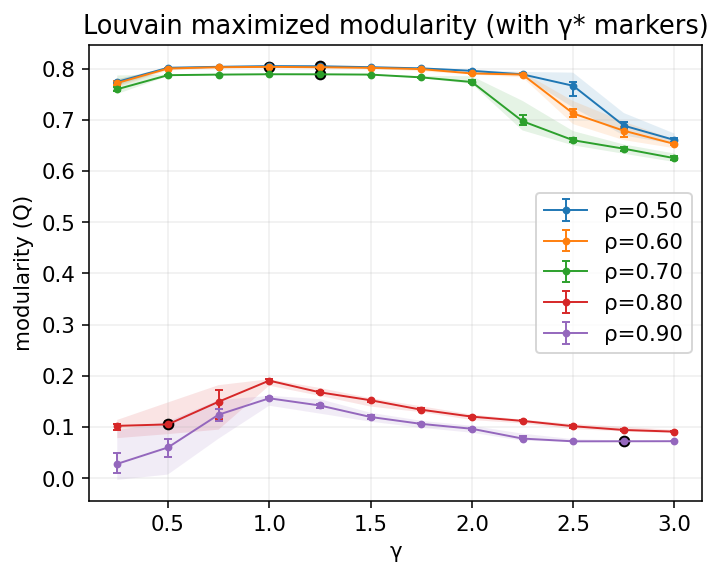

In [130]:
# Compute gamma* per rho from results (same rule as above)
gamma_star = {}
for rho in rhos:
    sub = results[results["rho"]==rho].sort_values("gamma")
    g = sub["gamma"].values
    q = sub["Q_med"].values
    d = np.abs(np.diff(q))
    gamma_star[rho] = g[np.argmin(d)+1] if len(d)>0 else 1.0

# Replot Panel 1 with markers
fig, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True)
for rho in rhos:
    sub = results[results["rho"]==rho].sort_values("gamma")
    ax.fill_between(sub["gamma"], sub["Q_lo"],  sub["Q_hi"], alpha=0.12)
    ax.errorbar(sub["gamma"], sub["Q_med"],
                yerr=[sub["Q_med"]-sub["Q_q25"], sub["Q_q75"]-sub["Q_med"]],
                fmt='-o', ms=3, lw=1, capsize=2, label=f"ρ={rho:.2f}")
    # filled marker at gamma*
    gstar = gamma_star[rho]
    ystar = float(sub.loc[sub["gamma"]==gstar, "Q_med"])
    ax.plot([gstar],[ystar],'ko', ms=5)

ax.set_xlabel(r"γ"); ax.set_ylabel("modularity (Q)")
ax.set_title("Louvain maximized modularity (with γ* markers)")
ax.grid(alpha=0.2); ax.legend()
plt.show()


In [171]:
import numpy as np, pandas as pd, networkx as nx, matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from collections import defaultdict

# df: columns ["disease1","disease2","weight"]
G = nx.from_pandas_edgelist(df, "disease1", "disease2", edge_attr=["weight"], create_using=nx.Graph)

# giant component only (optional but helpful for clean plots)
if not nx.is_connected(G):
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Louvain communities (γ=1)
partition = community_louvain.best_partition(G, weight="weight", resolution=1.0, random_state=42)
Q = community_louvain.modularity(partition, G, weight="weight")
print(f"Modularity Q = {Q:.3f}")

# node -> module id
node2mod = partition
# module -> set(nodes)
mod2nodes = defaultdict(list)
for n, m in node2mod.items():
    mod2nodes[m].append(n)



Modularity Q = 0.742


In [172]:
def top_intra_nodes(G, node2mod, mod_id, k=4):
    members = set(mod2nodes[mod_id])
    scores = []
    for u in members:
        s = 0.0
        for v, d in G[u].items():
            if v in members:
                s += float(d.get("weight", 1.0))
        scores.append((u, s))
    scores.sort(key=lambda x: x[1], reverse=True)
    return [u for (u, _) in scores[:k]]


In [173]:
# Layout (reused for all drawing)
pos = nx.spring_layout(G, seed=42, weight="weight", iterations=400)

# Edge backbone: keep top 20% strongest edges
E_sorted = sorted(G.edges(data=True), key=lambda e: e[2].get("weight", 0.0), reverse=True)
keep = max(8000, int(0.20 * len(E_sorted)))   # cap or 20%—tune for your graph size
E_draw = [(u, v) for (u, v, _) in E_sorted[:keep]]


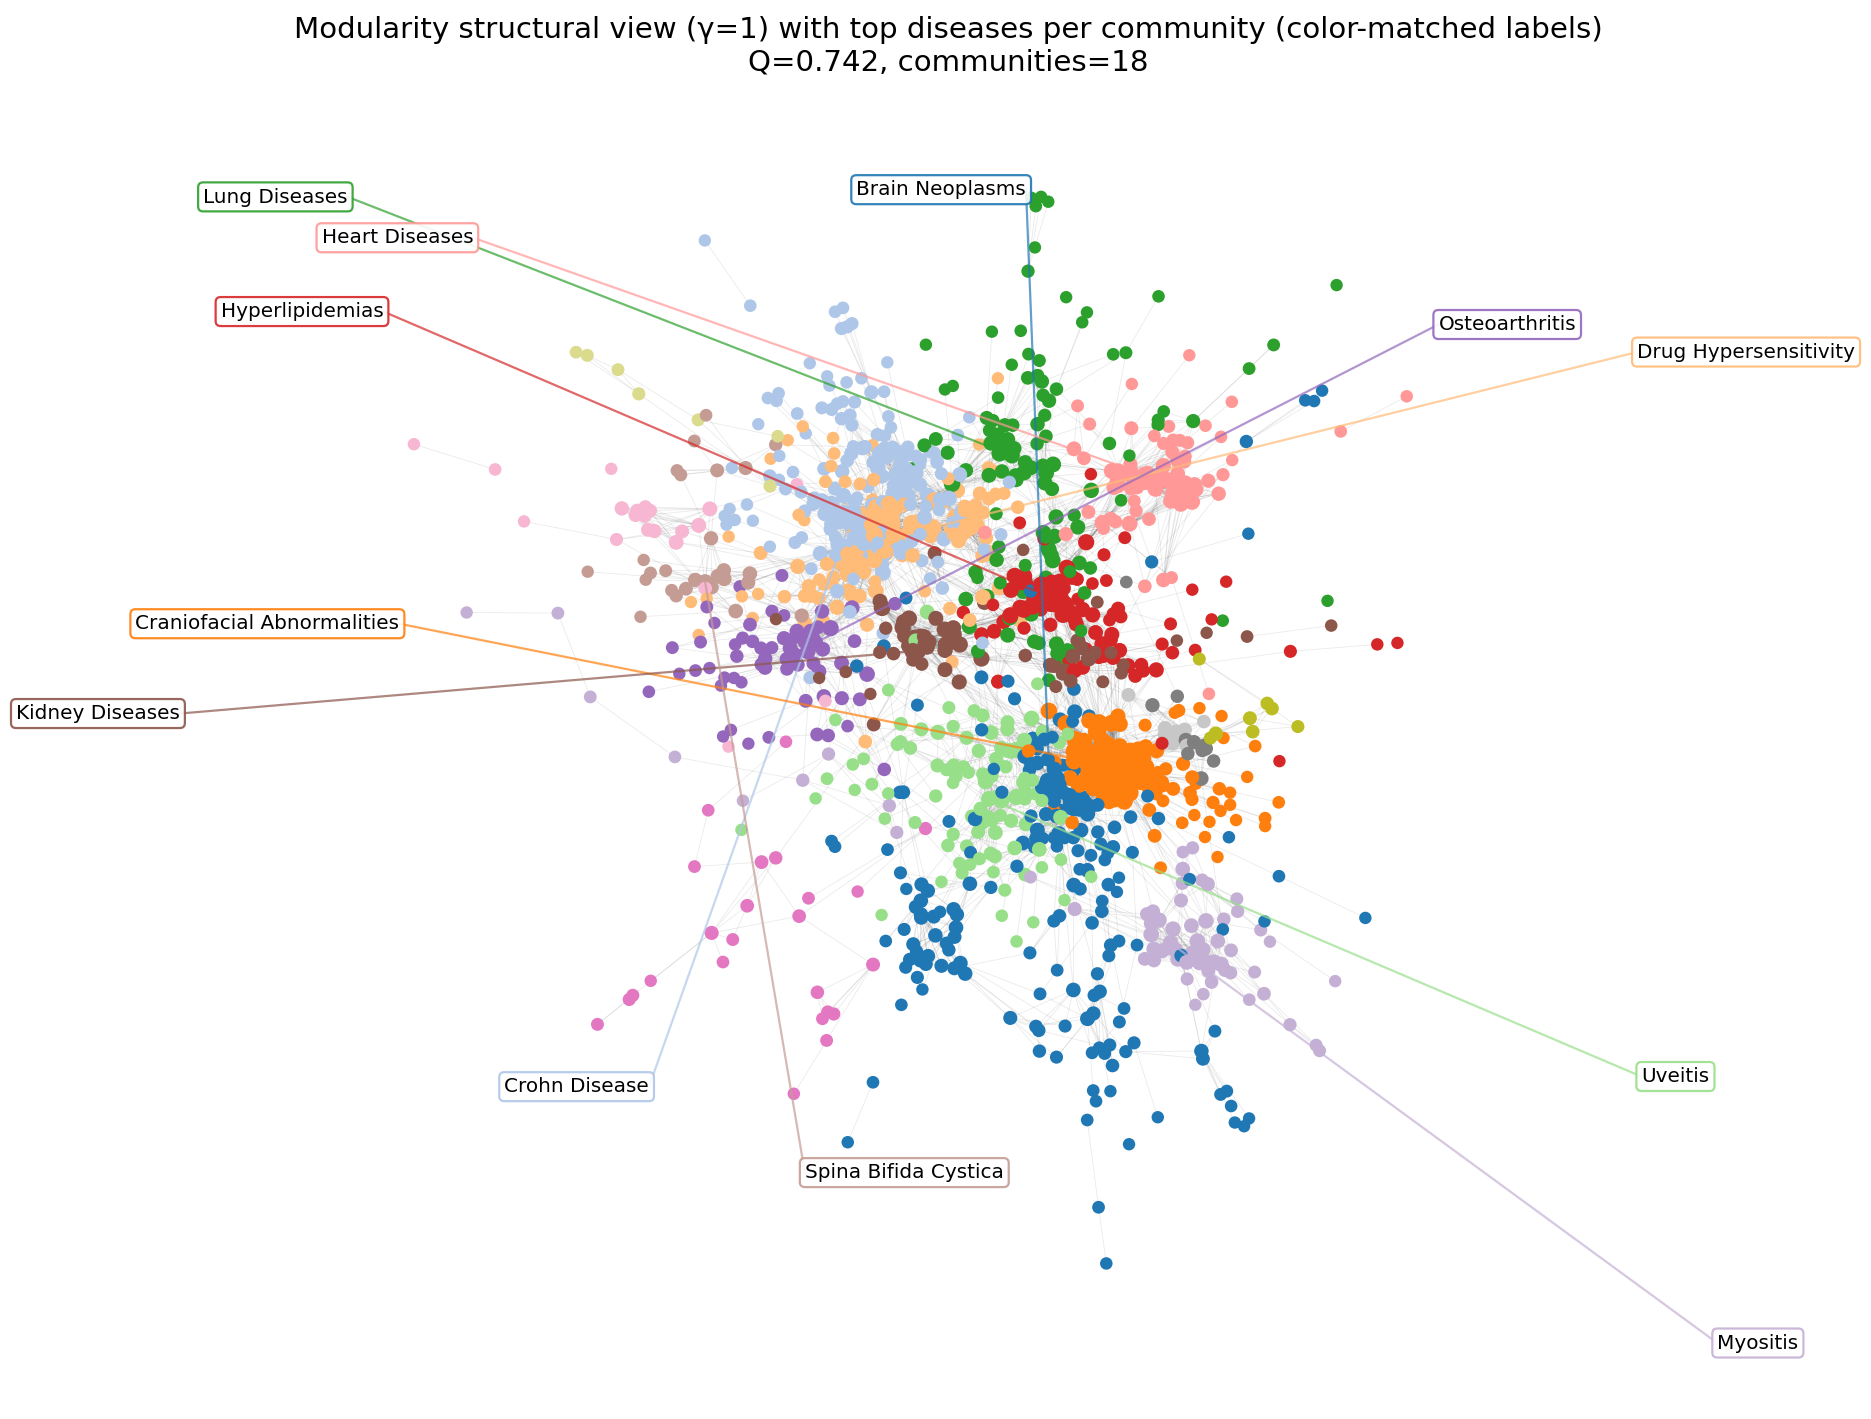

Saved: /content/fig_modularity_callouts.png


In [185]:
# Color map for communities
cmap = plt.get_cmap("tab20")
mods_sorted = sorted(mod2nodes.keys(), key=lambda m: -len(mod2nodes[m]))
mod2color = {m: cmap(i % 20) for i, m in enumerate(mods_sorted)}

# Node colors/sizes
node_color = [mod2color[node2mod[n]] for n in G.nodes()]
wdeg = np.array([G.degree(n, weight="weight") for n in G.nodes()], dtype=float)
node_size = 20 + 40*np.log10(1 + wdeg/wdeg.mean())   # tasteful scaling

fig, ax = plt.subplots(figsize=(12, 9), dpi=160)

# Draw edges first (light)
nx.draw_networkx_edges(G, pos, edgelist=E_draw, ax=ax, alpha=0.08, width=0.4, edge_color="k")

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, ax=ax)

# --- Callout labels per community ---
labels_per_comm = 1     # how many labels per community
r_offset = 0.99         # radial offset for label anchors
for m in mods_sorted:
    # skip tiny modules to keep figure clean
    if len(mod2nodes[m]) < 25:
        continue

    # exemplars
    exemplars = top_intra_nodes(G, node2mod, m, k=labels_per_comm)
    col = mod2color[m]
    # find cluster centroid for leader line direction
    pts = np.array([pos[n] for n in mod2nodes[m]])
    centroid = pts.mean(axis=0)

    for idx, n in enumerate(exemplars):
        x, y = pos[n]
        # vector from centroid to node → extend outward for label position
        v = np.array([x, y]) - centroid
        if np.allclose(v, 0):
            v = np.array([0.001, 0.001])
        v = v / np.linalg.norm(v)
        anchor = np.array([x, y]) + (r_offset + 0.05*idx) * v  # stagger a little

        # leader line
        ax.plot([x, anchor[0]], [y, anchor[1]], color=col, alpha=0.7, lw=1)

        # text box (color-matched edge)
        ax.text(anchor[0], anchor[1], n,
                fontsize=9,
                ha="left" if v[0] >= 0 else "right",
                va="center",
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec=col, lw=1, alpha=0.9))

ax.set_title(f"Modularity structural view (γ=1) with top diseases per community (color-matched labels)\nQ={Q:.3f}, communities={len(mod2nodes)}")
ax.axis("off")
plt.tight_layout()

out_path = "/content/fig_modularity_callouts.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out_path)
